# Analisis exploratorio de los datos

## Introduccion

La pandemia del COVID-19 ha impactado al mundo entero desde su aparición en diciembre de 2019. Desde entonces, se ha convertido en uno de los mayores desafíos de salud pública de nuestra época, afectando la vida de millones de personas y cambiando drásticamente la forma en que vivimos y trabajamos.

En este análisis de datos, se explorará la propagación del COVID-19 en varios países a lo largo del tiempo. Se utilizarán datos de casos confirmados, recuperados y fallecimientos para examinar patrones y tendencias en la evolución de la pandemia en diferentes regiones del mundo. Además, se analizará la eficacia de las medidas tomadas por los gobiernos para combatir la propagación del virus, así como la correlación entre la tasa de vacunación y la disminución de los casos.

El objetivo de este análisis es proporcionar una comprensión más profunda de la pandemia del COVID-19 y su impacto en diferentes países, con el fin de ayudar en la toma de decisiones informadas y en la implementación de medidas efectivas para combatir la propagación del virus.

## Importacion de Librerias

In [136]:
import os
import pandas as pd
import warnings
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
warnings.filterwarnings('ignore')

## Informacion de los datos

In [137]:
# Obtener el directorio actual
current_directory = os.getcwd()

# Leer un archivo CSV en el directorio actual utilizando pandas
data = pd.read_csv(current_directory + '/data/covid_19_data.csv', sep = ",")

# Imprimir los primeros 5 registros del archivo
data.head(5)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


Para poder trabajar con los datos, es importante revisar los valores disponibles. A continuación, se presentan los datos disponibles para su análisis.

* Sno - Numero de Serie
* ObservationDate - Fecha de observacion en formato (MM/DD/YYYY)
* Province/State - Provincia o estado de observación (Could be * empty when missing)
* Country/Region - Pais de observación
* Last Update - Hora en UTC en la que se actualiza la fila para la provincia o país dado. (No estandarizado, así que límpielo antes de usarlo)
* Confirmed - Número acumulado de casos confirmados hasta esa fecha
* Deaths - Número acumulado de muertes hasta esa fecha
* Recovered - Número acumulado de casos recuperados hasta esa fecha

In [138]:
print("Tamaño del dataset: ", data.shape)

Tamaño del dataset:  (306429, 8)


In [139]:
print("Tipo de datos en el dataset")
data.dtypes

Tipo de datos en el dataset


SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

In [140]:
print("Calculo de  valores nulos:")
data.isnull().sum()


Calculo de  valores nulos:


SNo                    0
ObservationDate        0
Province/State     78100
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

In [141]:
#Eliminamos la columna SNo
data.drop(["SNo"],1, inplace = True)

## Analisis a traves del tiempo

In [142]:
#Convertiremos la variable "Observation Date" en un formato Datetime
data["ObservationDate"] = pd.to_datetime(data["ObservationDate"])

In [143]:
#Agruparemos por pais/region y el dia de obervacion  pacientes confirmados, recuperados y fallecidos.
grouped_country=data.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

#Los pacientes activos de covid se calcula por los pacientes confirmados menos pacientes dados de alta y pacientes fallecidos.
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]

grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

In [144]:
#Agrupamos por dia de observacion para visualizar el crecimiento de pacientes activos, recuperados y fallecidos en el tiempo
datewise=data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [145]:
fig = px.bar(x = datewise.index, y = datewise["Confirmed"])
fig.update_layout(title = "Distribucion de pacientes confirmados", xaxis_title= "Date", yaxis_title = "Numero de casos")
fig.show()

In [146]:
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
fig.update_layout(title="Distribución de pacientes activos",
                  xaxis_title="Date",yaxis_title="Numero de casos",)
fig.show()

In [147]:
print("Informacion basica")
print("Numero total de paises contagiados por covid-19: ", len(data["Country/Region"].unique()))
print("Numero total de pacientes confirmados en el mundo: ",datewise["Confirmed"].iloc[-1])
print("Numero total de pacientes recuperados en el mundo ", datewise["Recovered"].iloc[-1])
print("Numero total de pacientes fallecidos en el mundo: ", datewise["Deaths"].iloc[-1])
print("Numero de pacientes confirmados en las ultimas 24 horas: ", datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Numero de pacientes recuperados en las ultimas 24 horas: ", datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Numero de pacientes fallecidos en las ultimas 24 horas: ", datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Informacion basica
Numero total de paises contagiados por covid-19:  229
Numero total de pacientes confirmados en el mundo:  169951560.0
Numero total de pacientes recuperados en el mundo  107140669.0
Numero total de pacientes fallecidos en el mundo:  3533619.0
Numero de pacientes confirmados en las ultimas 24 horas:  480835.0
Numero de pacientes recuperados en las ultimas 24 horas:  507600.0
Numero de pacientes fallecidos en las ultimas 24 horas:  10502.0


In [148]:
#vamos a analizar los datos por semana.

datewise["WeekofYear"] = datewise.index.weekofyear 

#Calculamos el numero de pacientes confirmados, recuperados y fallecidos por semana.

week_num = []
weekwise_confirmed = []
weekwise_recovered = []
weekwise_deaths = []
w = 1
for i in list(datewise["WeekofYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekofYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekofYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekofYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

In [149]:
weekwise_confirmed = sorted(weekwise_confirmed)
weekwise_recovered = sorted(weekwise_recovered)
weekwise_deaths = sorted(weekwise_deaths)

In [150]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

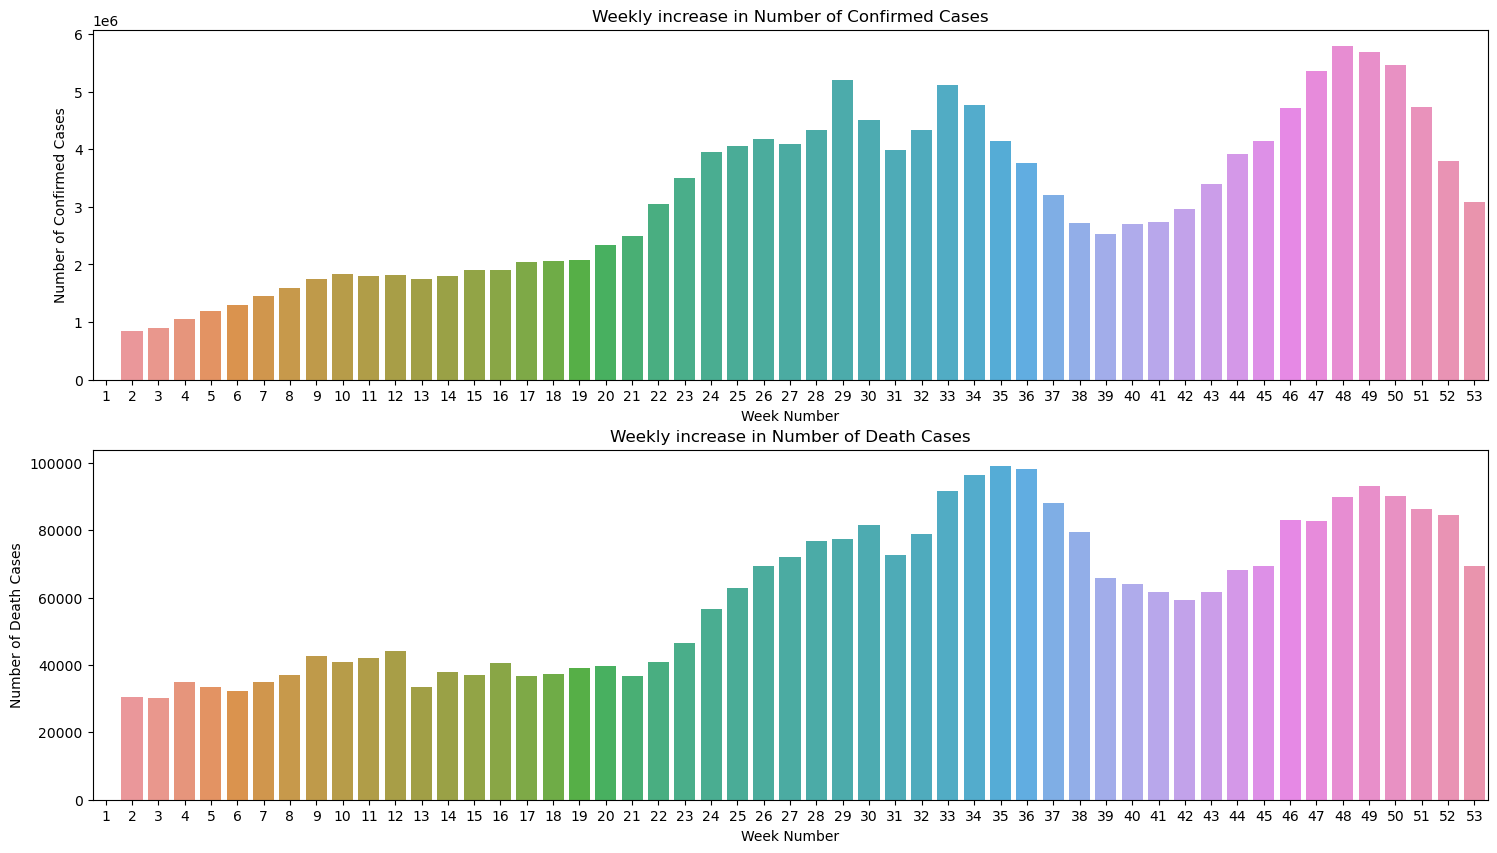

In [151]:
#Numero de pacientes confirmados y fallecidos por semana.

fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(18,10))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

## Ratio de recuperavilidad y Ratio de mortalidad

In [152]:
# Calculamos el indice de mortalidad y índice de recuperación.

datewise["Mortality_index"] = datewise["Deaths"]/datewise["Confirmed"]*100
datewise["Recovery_index"] = datewise["Recovered"]/datewise["Confirmed"]*100

print("indice de mortalidad medio: ", datewise["Mortality_index"].mean())
print("indice de recumerion medio: ", datewise["Recovery_index"].mean())

#Graficamos los indice por fecha

fig = make_subplots(rows = 2, cols =1, subplot_titles = ("Recovery Rate", "Mortality Rate"))

fig.add_trace(go.Scatter(x = datewise.index, y = datewise["Recovery_index"]), row= 1, col = 1)

fig.add_trace(go.Scatter(x = datewise.index, y = datewise["Mortality_index"]), row = 2, col = 1)

fig.update_layout(height=1000,legend=dict(x=0.4,y=0.5,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)

fig.show()

indice de mortalidad medio:  3.3985574175088837
indice de recumerion medio:  51.14820182446859


Al analizar la evolución de la pandemia, se observa que el índice de recuperación tuvo una caída abrupta en el mes de marzo, lo que indica que hubo una disminución significativa en la cantidad de pacientes recuperados durante ese período. Sin embargo, es importante destacar que, a medida que ha transcurrido el tiempo, el índice de recuperación ha ido aumentando gradualmente, lo que sugiere que se han implementado medidas efectivas para mejorar la capacidad de los sistemas de salud y atender mejor a los pacientes.

Por otro lado, el índice de mortalidad ha disminuido significativamente desde su pico más alto en el mes de mayo de 2020. Desde entonces, se ha observado una tendencia a la baja en los niveles de mortalidad, alcanzando sus niveles más bajos a partir del mes de diciembre del mismo año. Esto sugiere que, si bien la pandemia sigue siendo una amenaza para la salud pública, las medidas implementadas para combatirla están dando resultados positivos y se está logrando un mejor control de la propagación del virus

# Analisis por Pais/Region

In [153]:
# Vamos a analizar los indices de mortalidad y recuperavilidad por paises

Country = data[data["ObservationDate"] == data["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

Country["Mortality"] = (Country["Deaths"]/Country["Confirmed"])*100
Country["Recovery"] = (Country["Recovered"]/Country["Confirmed"])*100

#Vamos a calcular los pacientes confirmados, fallecidod y recuperados en las ultimas 24 horas
country_last24_confirmed = []
country_last24_deaths = []
country_last24_recovered = []

for country in Country.index:
    
    country_last24_confirmed.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Confirmed"])
    country_last24_deaths.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Deaths"])
    country_last24_recovered.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Recovered"])


In [154]:
Last_24_Hours_country=pd.DataFrame(list(zip(Country.index,country_last24_confirmed,country_last24_recovered,country_last24_deaths)),columns=["Country Name","Last 24 Hours Confirmed","Last 24 Hours Recovered","Last 24 Hours Deaths"])


Text(0.5, 1.0, 'Top 15 paises con el major numero de pacienes fallecidos en las ultimas 24 horas')

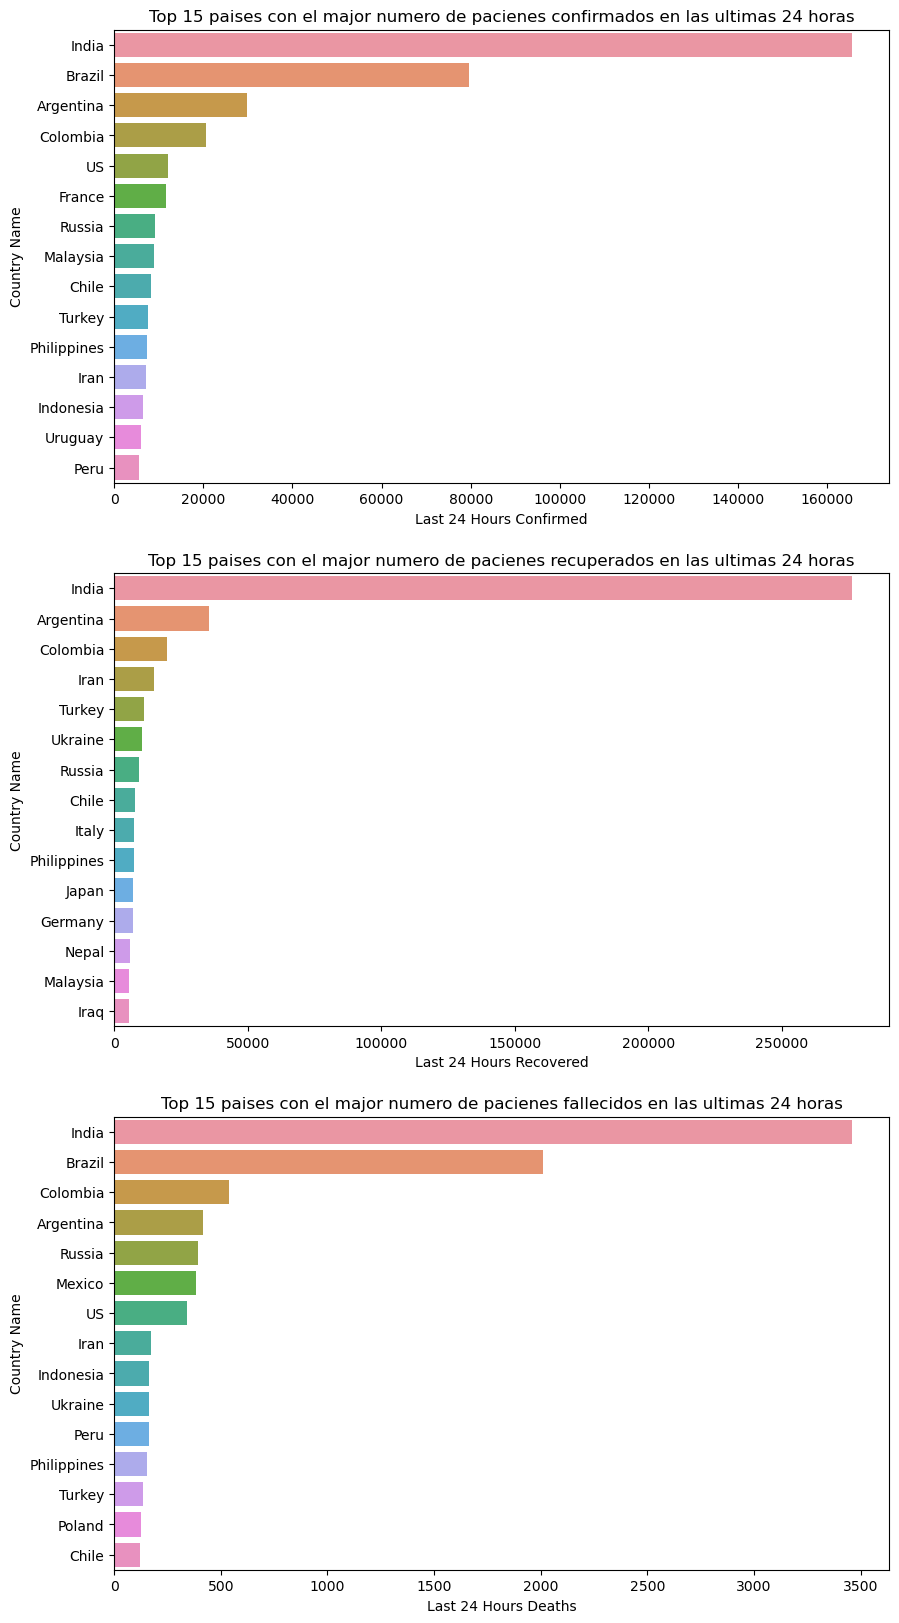

In [155]:
Top_15_Confirmed_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Confirmed"],ascending=False).head(15)
Top_15_Recoverd_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Recovered"],ascending=False).head(15)
Top_15_Deaths_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Deaths"],ascending=False).head(15)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,20))
sns.barplot(x=Top_15_Confirmed_24hr["Last 24 Hours Confirmed"],y=Top_15_Confirmed_24hr["Country Name"],ax=ax1)
ax1.set_title("Top 15 paises con el major numero de pacienes confirmados en las ultimas 24 horas")
sns.barplot(x=Top_15_Recoverd_24hr["Last 24 Hours Recovered"],y=Top_15_Recoverd_24hr["Country Name"],ax=ax2)
ax2.set_title("Top 15 paises con el major numero de pacienes recuperados en las ultimas 24 horas")
sns.barplot(x=Top_15_Deaths_24hr["Last 24 Hours Deaths"],y=Top_15_Deaths_24hr["Country Name"],ax=ax3)
ax3.set_title("Top 15 paises con el major numero de pacienes fallecidos en las ultimas 24 horas")

La tabla que presentamos a continuación indica la proporción de pacientes que han sido confirmados, recuperados y fallecidos en las últimas 24 horas, en comparación con el número total de pacientes que han sido confirmados, recuperados y fallecidos hasta la fecha.

In [156]:
Last_24_Hours_country["Proportion of Confirmed"]=(Last_24_Hours_country["Last 24 Hours Confirmed"]/(datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Recovered"]=(Last_24_Hours_country["Last 24 Hours Recovered"]/(datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Deaths"]=(Last_24_Hours_country["Last 24 Hours Deaths"]/(datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2]))*100
Last_24_Hours_country[["Country Name","Proportion of Confirmed","Proportion of Recovered","Proportion of Deaths"]].sort_values(["Proportion of Confirmed"],ascending=False).style.background_gradient(cmap="Reds")

,Country Name,Proportion of Confirmed,Proportion of Recovered,Proportion of Deaths
78,India,34.430314,54.434397,32.946106
23,Brazil,16.569093,0.694050,19.158256
6,Argentina,6.206079,7.018125,3.951628
36,Colombia,4.262169,3.873325,5.141878
182,US,2.490667,0.000000,3.266045
60,France,2.397288,0.134358,0.628452
144,Russia,1.903980,1.801812,3.761188
109,Malaysia,1.875903,1.088849,0.933156
35,Chile,1.708694,1.515957,1.133118
180,Turkey,1.592230,2.202522,1.304513


Analizamos el indice de mortalidad y recuperavilidad por paises a traves del tiempo.

In [157]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = datewise))

# Analisis de datos para Peru

In [158]:
# Filtraremos los datos para peru

peru_data = data[data['Country/Region'] == "Peru"]

date_Peru = peru_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

date_Peru.iloc[-1]

Confirmed    1947555.0
Recovered    1897522.0
Deaths         68978.0
Name: 2021-05-29 00:00:00, dtype: float64

In [188]:
# Visualizamos las curvas de crecimiento de diferente tipo de pacientes para el caso de Peru

fig = go.Figure()

fig.add_trace(go.Scatter(x = date_Peru.index, y = date_Peru['Confirmed'], mode = 'lines+markers', name = 'Pacientes confirmados'))
fig.add_trace(go.Scatter(x = date_Peru.index, y = date_Peru['Recovered'], mode = 'lines+markers', name = 'Pacientes recuperados'))
fig.add_trace(go.Scatter(x = date_Peru.index, y = date_Peru['Deaths'], mode = 'lines+markers', name = 'Pacientes fallecidos'))
fig.update_layout(title = "Curvas de crecimiento de diferentes tipos de pacientes del Perú", xaxis_title="Date" , yaxis_title = "Numero de casos")


## Clustering de paises segun Mortalidad y Recuperavilidad

In [160]:
# 
X=Country[["Mortality","Recovery"]]
#Standard Scaling since K-Means Clustering is a distance based alogrithm
std  = StandardScaler()

X=std.fit_transform(X) 

In [161]:
wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Elbow Method')

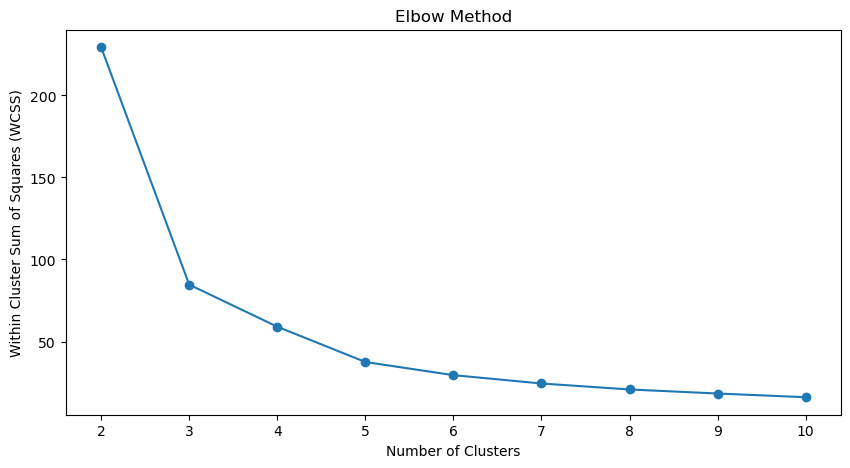

In [162]:
x=np.arange(2,11)
plt.figure(figsize=(10,5))
plt.plot(x,wcss,marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method")

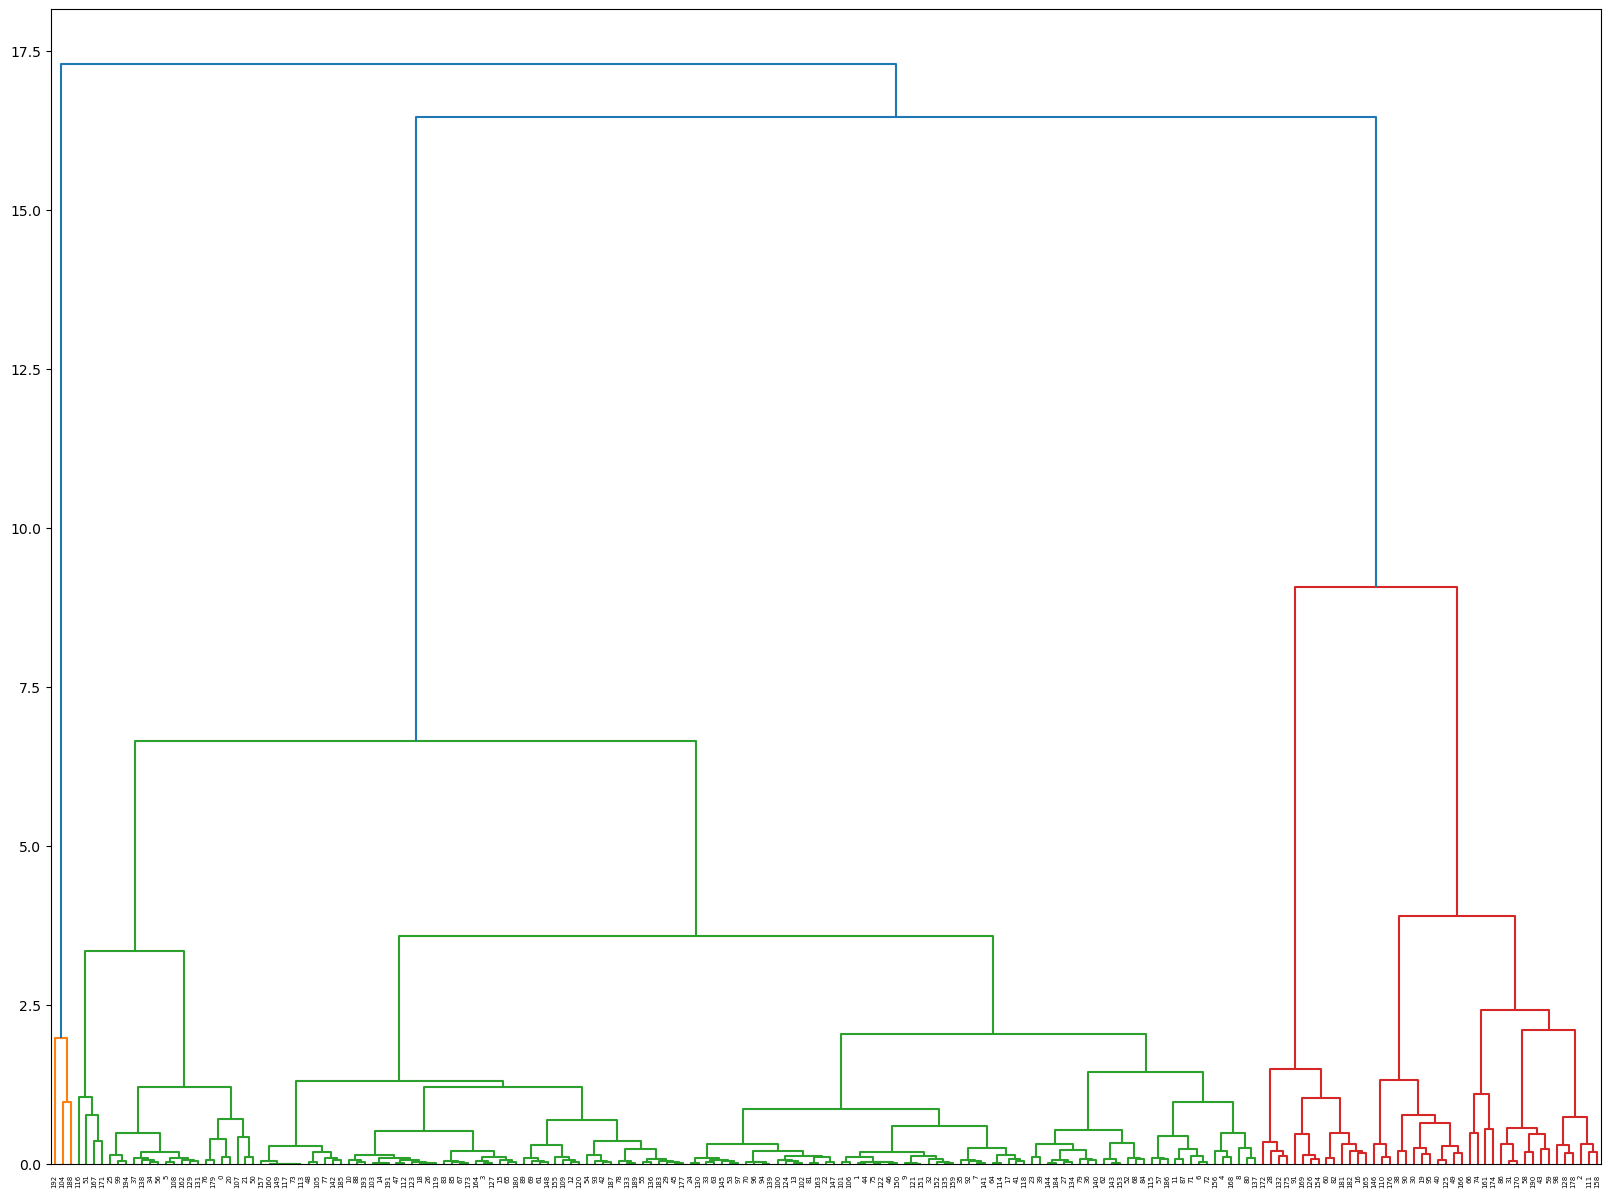

In [163]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(20,15))
dendogram=sch.dendrogram(sch.linkage(X, method  = "ward"))

In [164]:
clf_final=KMeans(n_clusters=3,init='k-means++',random_state=6)
clf_final.fit(X)

KMeans(n_clusters=3, random_state=6)

In [165]:
Country["Clusters"]=clf_final.predict(X)

In [166]:
cluster_summary=pd.concat([Country[Country["Clusters"]==1].head(15),Country[Country["Clusters"]==2].head(15),Country[Country["Clusters"]==0].head(15)])
cluster_summary.style.background_gradient(cmap='Blues').format("{:.2f}")

,Confirmed,Recovered,Deaths,Mortality,Recovery,Clusters
Country/Region,,,,,,
Belgium,1059763.00,0.00,24921.00,2.35,0.00,1.00
Burundi,4715.00,773.00,6.00,0.13,16.39,1.00
Cameroon,78929.00,35261.00,1275.00,1.62,44.67,1.00
Cyprus,72363.00,39061.00,360.00,0.50,53.98,1.00
Fiji,360.00,161.00,4.00,1.11,44.72,1.00
Finland,92244.00,46000.00,948.00,1.03,49.87,1.00
France,5719877.00,390878.00,109518.00,1.91,6.83,1.00
Greece,400395.00,93764.00,12024.00,3.00,23.42,1.00
Honduras,236952.00,84389.00,6296.00,2.66,35.61,1.00


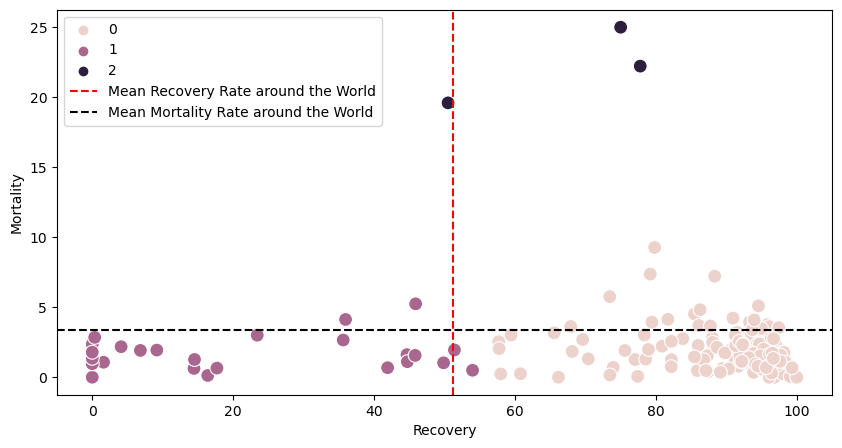

In [167]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=Country["Recovery"],y=Country["Mortality"],hue=Country["Clusters"],s=100)
plt.axvline(((datewise["Recovered"]/datewise["Confirmed"])*100).mean(),
            color='red',linestyle="--",label="Mean Recovery Rate around the World")
plt.axhline(((datewise["Deaths"]/datewise["Confirmed"])*100).mean(),
            color='black',linestyle="--",label="Mean Mortality Rate around the World")
plt.legend()

Vamos a analizar que pasises estan en cada cluster

In [168]:
print("Paises que pertenecen al cluster 0: \n\n", list(Country[Country["Clusters"] == 0].head(10).index))
print("\n")
print("Paises que pertenecen al cluster 1: \n\n", list(Country[Country["Clusters"] == 1].head(10).index))
print("\n")
print("Paises que pertenecen al cluster 2: \n\n", list(Country[Country["Clusters"] == 2].head(10).index))

Paises que pertenecen al cluster 0: 

 ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria']


Paises que pertenecen al cluster 1: 

 ['Belgium', 'Burundi', 'Cameroon', 'Cyprus', 'Fiji', 'Finland', 'France', 'Greece', 'Honduras', 'Ireland']


Paises que pertenecen al cluster 2: 

 ['MS Zaandam', 'Vanuatu', 'Yemen']


## Conclusión

Después de analizar los datos, se puede observar que los países pertenecientes al cluster 2 presentan una mayor tasa tanto de recuperación como de mortalidad en comparación con los países del cluster 1, que presentan una baja tasa de mortalidad y recuperación. Por otro lado, los países del cluster 0 presentan una alta tasa de recuperación con una baja tasa de mortalidad. Estos hallazgos sugieren que pertenecer a un cluster en particular puede estar relacionado con el desempeño del país en términos de la respuesta a la pandemia y pueden ser útiles para desarrollar estrategias y políticas adecuadas para enfrentar la pandemia.